In [1]:
import cantera as ct
import numpy as np
import time
#import scipy
import pandas as pd
import pylab
import matplotlib
import matplotlib.pyplot  as plt
import matplotlib.gridspec as gridspec
import os 
%matplotlib inline


print('This file was created by EHG on March 13, 2023')
print('Runnning Cantera version: ' + ct.__version__)

This file was created by EHG on March 13, 2023
Runnning Cantera version: 2.5.1


In [2]:
#load RMG model for C3H8 
mechfile = '/work/westgroup/nora/Code/projects/PFAS/models/C3H8_CH2F2/C3H8/C3H8_sevys_settings/cantera/chem_annotated.yaml'

In [3]:
gas_full=ct.Solution(mechfile)
# use this toggle to use either the full mechanism (True) or a smaller version (False)
#FullMech = False
FullMech = True

if FullMech==False:
    
    #exclude = ['CH2CCHCH2CHCH2'] #add specific species here. (for illustration purposes, since the Max_N_oxygen below would eliminate it anyway)
    max_N_carbon = 4
    max_N_oxygen = 3
    
    all_species = ct.Species.listFromFile(mechfile)
    species = []
    # Filter species
    for S in all_species:
#         if S.name in exclude:
#             print( "excluding %s"%(S.name) )
#             continue #skip this species
        comp = S.composition
        if S.name in ['C6H9', 'C6H10']:
            continue
        if 'C' in comp and comp['C']> max_N_carbon:
            print( "excluding %s"%(S.name) )
            continue
        if 'O' in comp and comp['O']> max_N_oxygen:
            print( "excluding %s"%(S.name) )
            continue            
#         if 'He' in comp: # Exclude Helium
#             print( "excluding %s"%(S.name) )
#             continue
#         if 'Ar' in comp: # Exclude Argon
#             print( "excluding %s"%(S.name) )
#             continue
#         if 'Kr' in comp: # Exclude Krypton
#             print( "excluding %s"%(S.name) )
#             continue   
        #print S.name    
        species.append(S)

    species_names = {S.name for S in species}
    # Filter reactions, keeping only those that only involve the selected species
    all_reactions = gas_full.reactions()
    reactions = []

    for R in all_reactions:
        if not all(reactant in species_names for reactant in R.reactants):
            continue
        if not all(product in species_names for product in R.products):
            continue
        reactions.append(R)

    gas_small = ct.Solution(thermo='IdealGas', kinetics='GasKinetics',
                       species=species, reactions=reactions)
    gas = gas_small    
else:
    gas = gas_full
    
print( "final mechanism has %d species and %d reactions"%(gas.n_species, gas.n_reactions) )
# i_ch3no2 = gas.species_index('CH3NO2')

final mechanism has 67 species and 860 reactions


In [4]:
def find_id(time,data):
    m = len(data)
    diff = np.zeros(m)
    diff_l = np.zeros(m)
    diff_r = np.zeros(m)
    a = 0
    for i in range(m):
        if i>1 and i<m-1:
            diff_l[i] = (data[i] - data[i-1])/(time[i]-time[i-1])
            diff_r[i] = (data[i+1] - data[i])/(time[i+1]-time[i])
            diff[i] = (diff_l[i]+diff_r[i])/2
    a = np.max(diff) #slope,m
    b = np.argmax(diff) #location of slope, x1
    
    #making of the function (y-y1 = m(x-x1)) 
    y = data[b] #location of y1
    x = time[b]  #location of x1 in terms of the modified time s
    
    t_id = -y/a+x #ignition delay location
    
    
    #returning the slope approximation function 
    
    lo = x-0.005
    hi = x+0.005
   
    x_0  = np.linspace(lo,hi)
    y_0 = a*(x_0-x)+y
    print(f'in the find_id function, found :{t_id}')
    return diff,t_id,x_0,y_0 

[{'C3H8(1)': 1, 'O2(2)': 6, 'Ar': 93}]
starting 1818.181818181818 of 0% CH2F2
Initializing reactor network.
Reactor 0: 70 variables.
              0 sensitivity params.
Number of equations: 70
Maximum time step:                0
in the find_id function, found :0.008855983072120486
starting 1775.700934579439 of 0% CH2F2
Initializing reactor network.
Reactor 0: 70 variables.
              0 sensitivity params.
Number of equations: 70
Maximum time step:                0
in the find_id function, found :0.015128733556746895
starting 1735.1598173515981 of 0% CH2F2
Initializing reactor network.
Reactor 0: 70 variables.
              0 sensitivity params.
Number of equations: 70
Maximum time step:                0
in the find_id function, found :0.018755786682309677
starting 1696.4285714285713 of 0% CH2F2
Initializing reactor network.
Reactor 0: 70 variables.
              0 sensitivity params.
Number of equations: 70
Maximum time step:                0
in the find_id function, found :0.027762

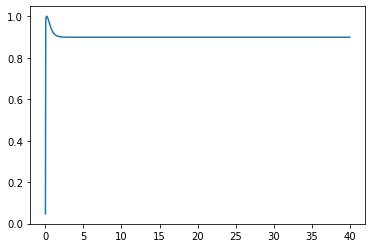

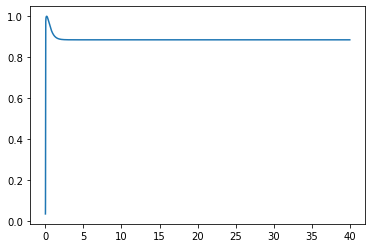

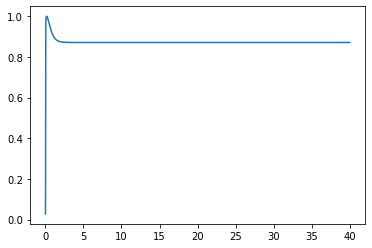

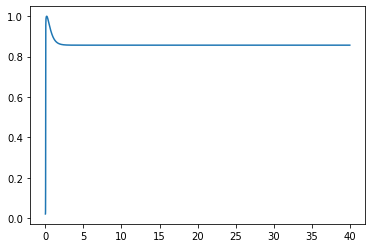

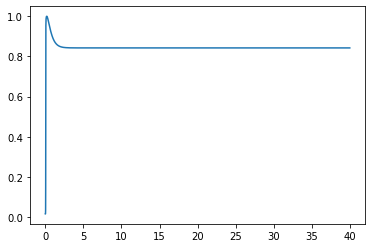

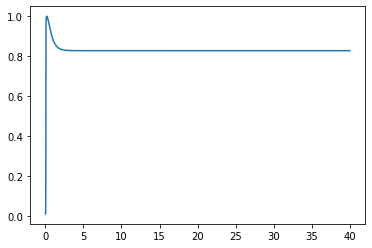

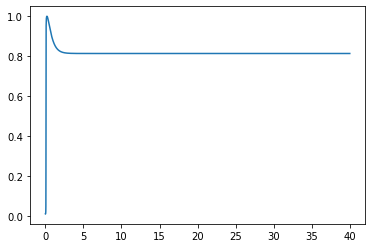

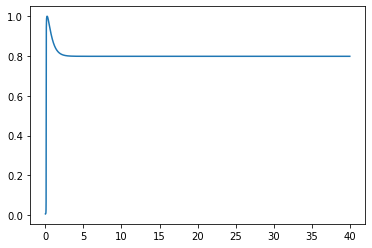

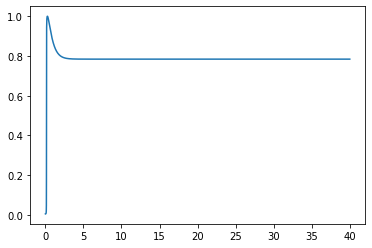

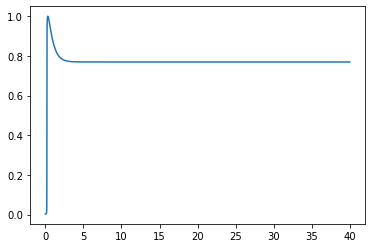

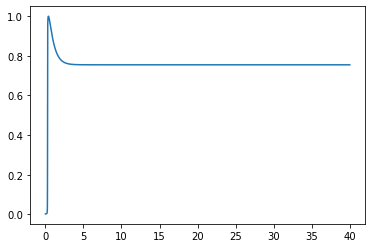

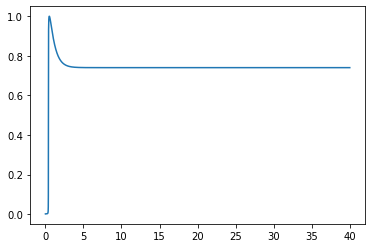

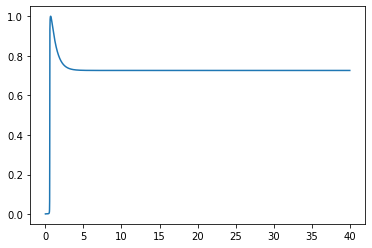

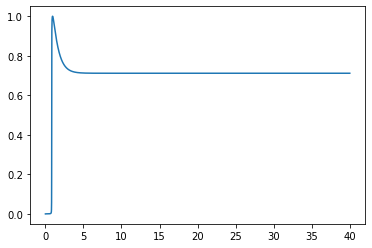

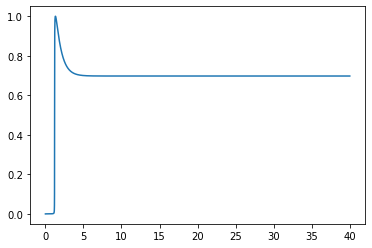

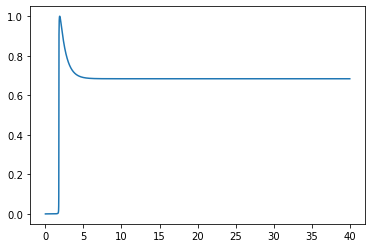

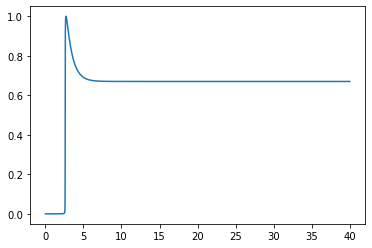

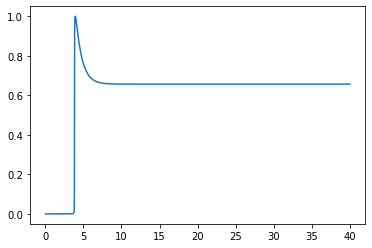

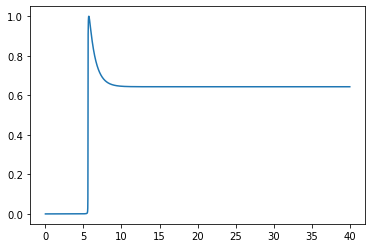

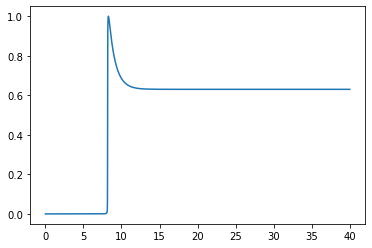

In [11]:
#doped propane (my model) 
T5 = [1818.181818181818,
 1775.700934579439,
 1735.1598173515981,
 1696.4285714285713,
 1659.3886462882097,
 1623.9316239316238,
 1589.9581589958157,
 1557.377049180328,
 1526.1044176706826,
 1496.062992125984,
 1467.1814671814673,
 1439.3939393939393,
 1412.6394052044607,
 1386.861313868613,
 1362.0071684587813,
 1338.0281690140844,
 1314.878892733564,
 1292.5170068027212,
 1270.9030100334448,
 1250.0]


T5_inverse = list(np.linspace(0.55, 0.8, 20))

X_list = [0]
concentrations = ['0']
conc_names = [{"C3H8(1)" : 1, "O2(2)":  6, "Ar" :93}]


master_dict={}

for index, x in enumerate(X_list): 

    mole_frac_dict = conc_names[index]
    print(conc_names)

    t_id_nuig = np.zeros(len(T5))
    for i in range(len(T5)):
        print(f'starting {T5[i]} of {concentrations[index]}% CH2F2')

        gas.TPX = T5[i],1*ct.one_atm, mole_frac_dict
        r = ct.Reactor(contents=gas)


        sim = ct.ReactorNet([r])
        sim.verbose = True


        states = ct.SolutionArray(gas, extra=['t'])

        dt_max = 5e-6
        t_end = (2000 * dt_max)*4

        while sim.time < t_end:
            sim.advance(sim.time + dt_max)
            states.append(r.thermo.state, t=sim.time*1e3)


        diff,t_id,x_0,y_0 = find_id(states.t,states.X[:, gas.species_index('OH(6)')]/np.max(states.X[:, gas.species_index('OH(6)')]))
        t_id_nuig[i] = t_id #id in ms

        #check to make sure we plotted far enough
        plt.figure()
        plt.plot(states.t,states.X[:, gas.species_index('OH(6)')]/np.max(states.X[:, gas.species_index('OH(6)')]))

    #save the data   
    master_dict[x] = t_id_nuig
    


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


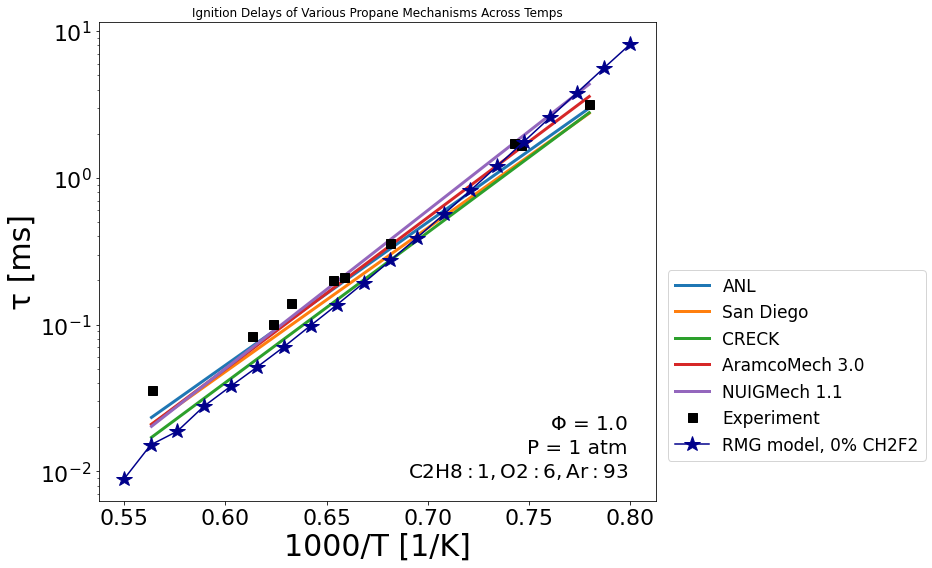

In [24]:
#This block plots the experiment with no ch2f2 with all of the models we campared.
full_path = '/work/westgroup/nora/Code/projects/PFAS/models/C3H8_CH2F2/plots/eduardos/'

plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['axes.labelsize'] = 30
plt.rcParams['xtick.labelsize'] = 22
plt.rcParams['ytick.labelsize'] = 22
plt.rcParams['figure.autolayout'] = True
matplotlib.rcParams['font.family'] = 'Times New Roman'


# Read CSV files
file_names = ['anl0.csv', 'sandiego.csv', 'creck.csv', 'aramco2.csv', 'nuig.csv']
mech_names = ['ANL','San Diego','CRECK','AramcoMech 3.0','NUIGMech 1.1','Experiment']
data = {}

##this is the section that reds the data points for the propane shocks
log_file_1 = full_path+'propane.csv'
log_df_1 = pd.read_csv(log_file_1,header=None)
T5_inv_1 = np.zeros(len(log_df_1.loc[0,:])) 
T5_inv_1[:] = log_df_1.loc[0,:]
tau_1 = np.zeros(len(log_df_1.loc[0,:]))
tau_1[:] = log_df_1.loc[1,:] #IDT
y_1 = np.zeros(len(log_df_1.loc[0,:]))
y_1[:] = log_df_1.loc[2,:] #linear interpolation
T5_inv_model_1 = np.zeros(len(log_df_1.loc[3,:]))
T5_inv_model_1[:] = log_df_1.loc[3,:] #model x
tau_model_1 = np.zeros(len(log_df_1.loc[3,:]))
tau_model_1[:] = log_df_1.loc[4,:] #model y 
P5_1 = np.zeros(len(log_df_1.loc[3,:]))
P5_1[:] = log_df_1.loc[5,:] #model y 

prop_inv_T = T5_inv_1
prop_tau = tau_1

for file_name in file_names:
    df = pd.read_csv(full_path+file_name)
    K_full = df['K_full']
    N_full = df['N_full']
    N_small = df['N_small']
    K_small = df['K_small']
    x = df['x']
    y = df['y']
    data[file_name] = {'x': x, 'y': y, 'k_full':K_full,'n_full':N_full,'k_small':K_small,'n_small':N_small}



i=0
table_data = []
for file_name, values in data.items():
    x = values['x']
    y = values['y']
    k_f = values['k_full']
    n_f = values['n_full']
    k_s = values['k_small']
    n_s = values['n_small']
    
    
    K_full = k_f[0]
    N_full = n_f[0]
    K_small = k_s[0]
    N_small = n_s[0]
    table_data.append({'File Name': mech_names[i], '#Reactions': K_full, '#Species': N_full,'Reduced #Reactions': K_small, 'Reduced #Species': N_small,})

    plt.semilogy(x, y, label=f'{mech_names[i]}', linewidth=3)
    i+=1
plt.semilogy(T5_inv_1,tau_1,'sk',label='Experiment',markersize=9)



#my model
X_list = [0]#,0.1,0.5,2,4]
colors = [no_CH2F2_color]

for x, color in zip(X_list, colors):
    taus = master_dict[x]
    taus_to_plot = [tau for tau in taus if tau>0]
    temp_to_plot = [1000/t for t in T5[0:len(taus_to_plot)]]
    plt.semilogy(temp_to_plot, taus_to_plot, '-*', c='darkblue', label=f'RMG model, {x}% CH2F2', markersize=16) 

plt.title('Ignition Delays of Various Propane Mechanisms Across Temps')
plt.xlabel('1000/T [1/K]')
plt.ylabel('τ [ms]')
plt.legend(fontsize=17, bbox_to_anchor=(1.5, 0.5))
plt.text(0.95, 0.05, r'$\mathrm{C2H8:1, O2:6, Ar:93}$', transform=plt.gca().transAxes, horizontalalignment='right',fontsize=20)
plt.text(0.95, 0.10, 'P = 1 atm', transform=plt.gca().transAxes, horizontalalignment='right',fontsize=20)
plt.text(0.95, 0.15, '$\Phi$ = 1.0', transform=plt.gca().transAxes, horizontalalignment='right',fontsize=20)
plt.show()
    